# [How to Develop Deep Learning Models for Univariate Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/)

**Author:** [Jason Brownlee](https://machinelearningmastery.com/) on October 29, 2018 in [Deep Learning for Time Series](https://machinelearningmastery.com/category/deep-learning-time-series/).

**Modifications:** Alex Araujo

## Initial setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import (Dense, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed, 
                          ConvLSTM2D)   
from keras.utils import plot_model
   
%matplotlib inline

Using TensorFlow backend.


## Problem description

In [3]:
# Benchmark.
SARIMA = 1551.842

In [4]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv \
-O ./monthly_car_sales.csv 

--2019-11-05 18:56:24--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.4.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.4.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1834 (1,8K) [text/plain]
Saving to: ‘./monthly_car_sales.csv’

./monthly_car_sales 100%[===================>]   1,79K  --.-KB/s    in 0s      

2019-11-05 18:56:25 (62,1 MB/s) - ‘./monthly_car_sales.csv’ saved [1834/1834]



In [5]:
# Load data.
series = pd.read_csv("monthly_car_sales.csv", header=0, index_col=0)

In [6]:
# Summarize shape.
print(series.shape)

(108, 1)


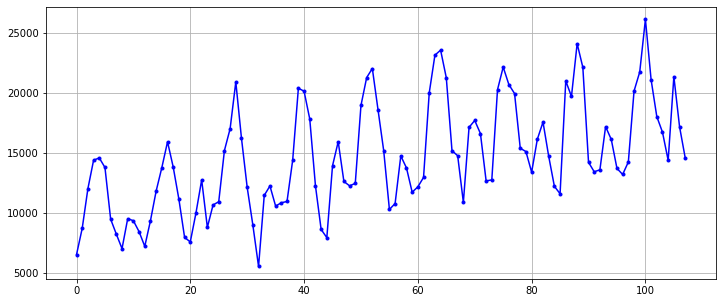

In [7]:
# Plot.
plt.figure(figsize=(12, 5))
plt.plot(series.values, ".-b")
plt.grid();

## Model Evaluation Test Harness

In [8]:
# Split a univariate dataset into train/test sets.
def train_test_split(data, n_test):

    return data[:-n_test], data[-n_test:]

In [9]:
# Transform list into supervised learning format.
def series_to_supervised(data, n_in=1, n_out=1):

    df = pd.DataFrame(data)
    cols = list()
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    
    # Drop rows with NaN values.
    agg.dropna(inplace=True)

    return agg.values

In [10]:
# Root mean squared error or rmse.
def measure_rmse(actual, predicted):

    return sqrt(mean_squared_error(actual, predicted))

In [11]:
# Difference dataset.
def difference(data, interval):

    return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [12]:
# Fit a model.
def model_fit(train, config):

    return None

In [13]:
# Forecast with a pre-fit model.
def model_predict(model, history, config):
    
    values = list()
    
    for offset in config:
        values.append(history[-offset])
    
    return np.median(values)

In [14]:
# Walk-forward validation for univariate data.
def walk_forward_validation(data, n_test, cfg):

    predictions = list()

    # Split dataset.
    train, test = train_test_split(data, n_test)

    # Fit model.
    model = model_fit(train, cfg)

    # Seed history with training dataset.
    history = [x for x in train]

    # Step over each time-step in the test set.
    for i in range(len(test)):

        # Fit model and make forecast for history.
        yhat = model_predict(model, history, cfg)

        # Store forecast in list of predictions.
        predictions.append(yhat)

        # Add actual observation to history for the next loop.
        history.append(test[i])
        
    # Estimate prediction error.
    error = measure_rmse(test, predictions)
    print(" > %.3f" % error)

    return error

In [15]:
# Repeat evaluation of a config.
def repeat_evaluate(data, config, n_test, n_repeats=30):

    # Fit and evaluate the model n times.
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]

    return scores

In [16]:
# Summarize model performance.
def summarize_scores(name, scores):

    # Print a summary.
    scores_m, score_std = np.mean(scores), np.std(scores)

    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))

    # Box and whisker plot.
    plt.boxplot(scores)

 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
persistence: 1841.156 RMSE (+/- 0.000)
CPU times: user 106 ms, sys: 7.2 ms, total: 114 ms
Wall time: 115 ms


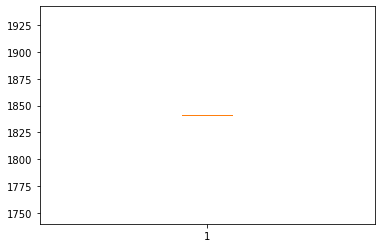

In [17]:
%%time

data = series.values

# Data split.
n_test = 12

# Define config.
config = [12, 24, 36]

# Grid search.
persistence_scores = repeat_evaluate(data, config, n_test)

# Summarize scores.
summarize_scores("persistence", persistence_scores)

## Multilayer Perceptron

In [18]:
# Fit a model.
def model_fit(train, config):

    # Unpack config.
    n_input, n_nodes, n_epochs, n_batch = config

    # Prepare data.
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]

    # Define model.
    model = Sequential()
    model.add(Dense(n_nodes, activation="relu", input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")

    fp = "./figures/" + \
         "how_to_develop_deep_learning_models_for_univariate_time_series_forecasting_" + \
         "mlp.png"
    
    if not os.path.exists(fp):
        plot_model(model=model, to_file=fp, show_shapes=True)    
        
    # Fit.
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

In [19]:
# Forecast with a pre-fit model.
def model_predict(model, history, config):

    # Unpack config.
    n_input, _, _, _ = config

    # Prepare data.
    x_input = np.array(history[-n_input:]).reshape(1, n_input)

    # Forecast.
    yhat = model.predict(x_input, verbose=0)

    return yhat[0]

In [20]:
# Define config.
config = [24, 500, 100, 100]

In [21]:
%%time

# Grid search.
mlp_scores = repeat_evaluate(data, config, n_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
 > 1435.074
 > 1556.476
 > 1578.130
 > 1570.340
 > 1432.733
 > 1407.393
 > 1745.726
 > 1463.306
 > 1713.101
 > 1319.686
 > 1661.349
 > 1545.694
 > 1821.823
 > 1557.818
 > 1511.149
 > 1718.330
 > 1502.213
 > 1607.423
 > 1710.736
 > 1591.320
 > 1428.208
 > 1636.612
 > 1330.164
 > 1719.534
 > 1752.136
 > 1261.307
 > 1551.905
 > 1508.341
 > 1696.890
 > 1556.501
CPU times: user 33.8 s, sys: 532 ms, total: 34.3 s
Wall time: 31.8 s


mlp: 1563.047 RMSE (+/- 137.260)


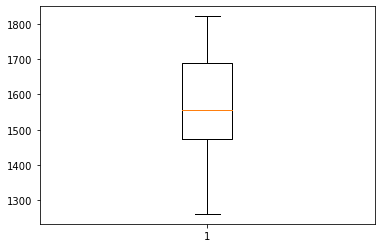

In [22]:
# Summarize scores.
summarize_scores("mlp", mlp_scores)

## Convolutional Neural Network Model

In [23]:
# Define and fit model.
def model_fit(train, config):

    # Unpack config.
    n_input, n_filters, n_kernel, n_epochs, n_batch = config

    # Prepare data.
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

    # Define model.
    model = Sequential()
    model.add(Conv1D(filters=n_filters, 
                     kernel_size=n_kernel, 
                     activation="relu", 
                     input_shape=(n_input, 1)))
    model.add(Conv1D(filters=n_filters, 
                     kernel_size=n_kernel, 
                     activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    
    # Compilation.
    model.compile(loss="mse", optimizer="adam")

    # Fit.
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)

    fp = "./figures/" + \
         "how_to_develop_deep_learning_models_for_univariate_time_series_forecasting_" + \
         "cnn.png"
    
    if not os.path.exists(fp):
        plot_model(model=model, to_file=fp, show_shapes=True)
    
    return model

In [24]:
# Forecast with a pre-fit model.
def model_predict(model, history, config):

    # Unpack config.
    n_input, _, _, _, _ = config

    # Prepare data.
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))

    # Forecast.
    yhat = model.predict(x_input, verbose=0)
    
    return yhat[0]

 > 1466.132
 > 1478.632
 > 1631.610
 > 1525.763
 > 1566.426
 > 1653.644
 > 1604.627
 > 1590.286
 > 1623.690
 > 1536.600
 > 1814.786
 > 1578.397
 > 1551.623
 > 1553.597
 > 1553.979
 > 1581.768
 > 1544.961
 > 1605.750
 > 1601.840
 > 1647.376
 > 1479.949
 > 1523.648
 > 1570.106
 > 1780.876
 > 1612.609
 > 1616.959
 > 1552.759
 > 1506.436
 > 1567.920
 > 1492.504
cnn: 1580.508 RMSE (+/- 75.980)
CPU times: user 7min 36s, sys: 6.49 s, total: 7min 42s
Wall time: 3min 17s


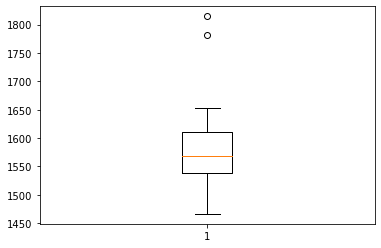

In [25]:
%%time

data = series.values

# Data split.
n_test = 12

# Define config.
config = [36, 256, 3, 100, 100]

# Grid search.
cnn_scores = repeat_evaluate(data, config, n_test)

# Summarize scores.
summarize_scores("cnn", cnn_scores)

## Recurrent Neural Network Models    

### LSTM

In [26]:
# Difference dataset.
def difference(data, interval):

    return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [27]:
# Fit a model.
def model_fit(train, config):

    # Unpack config.
    n_input, n_nodes, n_epochs, n_batch, n_diff = config

    # Prepare data.
    if n_diff > 0:
        train = difference(train, n_diff)

    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

    # Define model.
    model = Sequential()
    model.add(LSTM(n_nodes, 
                   activation="relu", 
                   input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, 
                    activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")

    # Fit.
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)

    fp = "./figures/" + \
    "how_to_develop_deep_learning_models_for_univariate_time_series_forecasting_" + \
    "lstm.png"

    if not os.path.exists(fp):
        plot_model(model=model, to_file=fp, show_shapes=True) 

    return model

In [28]:
# Forecast with a pre-fit model.
def model_predict(model, history, config):

    # Unpack config.
    n_input, _, _, _, n_diff = config

    # Prepare data.
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)

    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))

    # Forecast.
    yhat = model.predict(x_input, verbose=0)

    return correction + yhat[0]

 > 2076.990
 > 2136.290
 > 2151.593
 > 2145.067
 > 1717.144
 > 2087.068
 > 2188.624
 > 2171.907
 > 2081.383
 > 1964.839
 > 2094.985
 > 2209.185
 > 2035.977
 > 2079.507
 > 2086.865
 > 2060.563
 > 2047.583
 > 2095.968
 > 2045.900
 > 2076.846
 > 2185.390
 > 2167.150
 > 1965.271
 > 2081.656
 > 2146.156
 > 2175.196
 > 2004.790
 > 2188.835
 > 2049.170
 > 2192.608
lstm: 2090.350 RMSE (+/- 95.349)
CPU times: user 6min 5s, sys: 19 s, total: 6min 24s
Wall time: 4min 46s


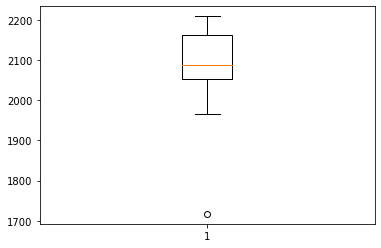

In [29]:
%%time

series = pd.read_csv("monthly_car_sales.csv", header=0, index_col=0)
data = series.values

# Data split.
n_test = 12

# Define config.
config = [36, 50, 100, 100, 12]

# Grid search.
lstm_scores = repeat_evaluate(data, config, n_test)

# Summarize scores.
summarize_scores("lstm", lstm_scores)

### CNN LSTM

In [30]:
# Fit a model.
def model_fit(train, config):

    # Unpack config.
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps

    # Prepare data.
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))

    # Define model.
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, 
                                     kernel_size=n_kernel, 
                                     activation="relu", 
                                     input_shape=(None, n_steps, 1))))
    model.add(TimeDistributed(Conv1D(filters=n_filters, 
                                     kernel_size=n_kernel, 
                                     activation="relu")))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation="relu"))
    model.add(Dense(n_nodes, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")

    # Fit.
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)

    fp = "./figures/" + \
         "how_to_develop_deep_learning_models_for_univariate_time_series_forecasting_" + \
         "cnn_lstm.png"

    if not os.path.exists(fp):
        plot_model(model=model, to_file=fp, show_shapes=True)     

    return model

In [31]:
# Forecast with a pre-fit model.
def model_predict(model, history, config):
	
    # Unpack config.
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps

    # Prepare data.
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))

    # Forecast.
    yhat = model.predict(x_input, verbose=0)

    return yhat[0]

 > 1681.790
 > 1991.258
 > 1976.016
 > 1519.562
 > 2118.995
 > 1810.103
 > 2553.140
 > 1615.988
 > 1495.462
 > 1507.207
 > 1604.885
 > 1350.875
 > 1715.707
 > 1556.378
 > 1893.131
 > 1445.280
 > 1843.504
 > 1897.411
 > 1630.513
 > 1616.739
 > 1673.430
 > 1344.857
 > 1702.854
 > 1637.682
 > 1817.394
 > 1756.588
 > 1583.224
 > 1588.749
 > 1602.232
 > 1489.368
cnn-lstm: 1700.677 RMSE (+/- 241.416)
CPU times: user 11min 49s, sys: 15.3 s, total: 12min 4s
Wall time: 9min 41s


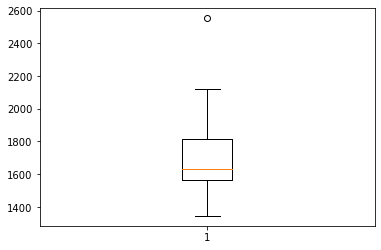

In [32]:
%%time

series = pd.read_csv("monthly_car_sales.csv", header=0, index_col=0)
data = series.values

# Data split.
n_test = 12

# Define config.
config = [3, 12, 64, 3, 100, 200, 100]

# Grid search.
cnn_lstm_scores = repeat_evaluate(data, config, n_test)

# Summarize scores.
summarize_scores("cnn-lstm", cnn_lstm_scores)

### CNN LSTM Causal

In [33]:
# Fit a model.
def model_fit(train, config):

    # Unpack config.
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps

    # Prepare data.
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))

    # Define model.
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, 
                                     kernel_size=n_kernel, 
                                     activation="relu", 
                                     padding="causal",
                                     input_shape=(None, n_steps, 1))))
    model.add(TimeDistributed(Conv1D(filters=n_filters, 
                                     kernel_size=n_kernel, 
                                     activation="relu",
                                     padding="causal")))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation="relu"))
    model.add(Dense(n_nodes, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")

    # Fit.
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)

    fp = "./figures/" + \
         "how_to_develop_deep_learning_models_for_univariate_time_series_forecasting_" + \
         "cnn_lstm_causal.png"

    if not os.path.exists(fp):
        plot_model(model=model, to_file=fp, show_shapes=True)     

    return model

 > 1524.652
 > 1424.429
 > 1365.916
 > 1348.883
 > 1468.302
 > 1678.207
 > 1843.643
 > 1606.316
 > 1138.502
 > 1253.292
 > 1372.491
 > 1503.350
 > 1437.172
 > 1430.178
 > 1474.951
 > 1850.170
 > 1400.052
 > 1521.147
 > 1435.148
 > 1437.831
 > 1635.276
 > 1644.160
 > 1573.618
 > 1603.468
 > 1418.431
 > 1550.378
 > 1367.049
 > 1533.104
 > 1520.002
 > 1476.210
cnn-lstm-causal: 1494.544 RMSE (+/- 147.301)
CPU times: user 18min 43s, sys: 17 s, total: 19min
Wall time: 15min 58s


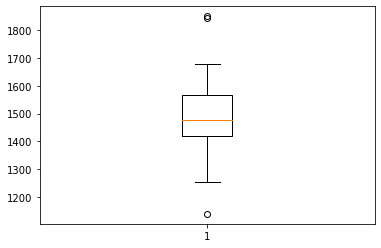

In [34]:
%%time

series = pd.read_csv("monthly_car_sales.csv", header=0, index_col=0)
data = series.values

# Data split.
n_test = 12

# Define config.
config = [3, 12, 64, 3, 100, 200, 100]

# Grid search.
cnn_lstm_causal_scores = repeat_evaluate(data, config, n_test)

# Summarize scores.
summarize_scores("cnn-lstm-causal", cnn_lstm_causal_scores)

### ConvLSTM

In [35]:
# Fit a model.
def model_fit(train, config):

    # Unpack config.
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps

    # Prepare data.
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))

    # Define model.
    model = Sequential()
    model.add(ConvLSTM2D(filters=n_filters, 
                         kernel_size=(1, n_kernel), 
                         activation="relu", 
                         input_shape=(n_seq, 1, n_steps, 1)))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")

    # Fit.
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)

    fp = "./figures/" + \
         "how_to_develop_deep_learning_models_for_univariate_time_series_forecasting_" + \
         "conv_lstm.png"

    if not os.path.exists(fp):
        plot_model(model=model, to_file=fp, show_shapes=True)

    return model

In [36]:
# Forecast with a pre-fit model.
def model_predict(model, history, config):

    # Unpack config.
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps

    # Prepare data.
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))

    # Forecast.
    yhat = model.predict(x_input, verbose=0)

    return yhat[0]

 > 1818.868
 > 1707.823
 > 1718.644
 > 1572.087
 > 1510.945
 > 1534.534
 > 1793.824
 > 1710.876
 > 1594.138
 > 2034.144
 > 1604.127
 > 1766.542
 > 1599.107
 > 2028.315
 > 2205.391
 > 1428.159
 > 2023.503
 > 1906.900
 > 1502.905
 > 1908.745
 > 1559.235
 > 1574.371
 > 1666.172
 > 2009.099
 > 1477.949
 > 1592.459
 > 1454.943
 > 2048.716
 > 1819.445
 > 1952.839
conv-lstm: 1737.494 RMSE (+/- 210.351)
CPU times: user 1h 21min 23s, sys: 1min 16s, total: 1h 22min 39s
Wall time: 39min 18s


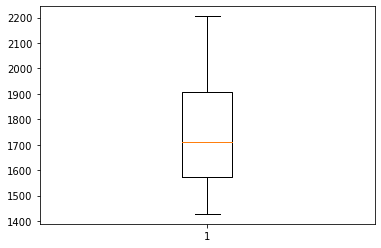

In [37]:
%%time

series = pd.read_csv("monthly_car_sales.csv", header=0, index_col=0)
data = series.values

# Data split.
n_test = 12

# Define config.
config = [3, 12, 256, 3, 200, 200, 100]

# Grid search.
conv_lstm_scores = repeat_evaluate(data, config, n_test)

# Summarize scores.
summarize_scores("conv-lstm", conv_lstm_scores)

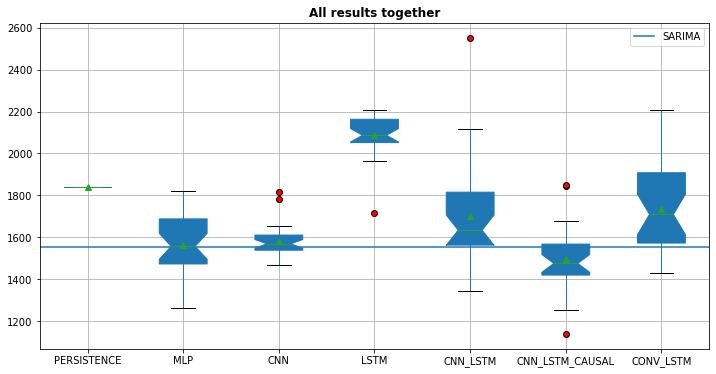

In [38]:
# Compare all results.
results = [persistence_scores]
results.append(mlp_scores)
results.append(cnn_scores)
results.append(lstm_scores)
results.append(cnn_lstm_scores)
results.append(cnn_lstm_causal_scores)
results.append(conv_lstm_scores)
pd.DataFrame(data=np.array(results).T,
             columns=["PERSISTENCE", 
                      "MLP", 
                      "CNN", 
                      "LSTM", 
                      "CNN_LSTM", 
                      "CNN_LSTM_CAUSAL", 
                      "CONV_LSTM"]).boxplot(figsize=(12, 6),
                                            patch_artist=True,
                                            notch=True, 
                                            showmeans=True,
                                            flierprops={"markerfacecolor": "red",
                                                        "marker": "o"}) 
plt.axhline(y=SARIMA, label="SARIMA")
plt.title("All results together", weight="bold")
plt.legend()
plt.savefig("./figures/" + \
            "how_to_develop_deep_learning_models_for_univariate_time_series_forecasting_all.png", 
            bbox_inches="tight")